# Detrending CMIP6 models 

This notebook is the main processing pipeline to calculate control run drift, which can then be easily removed from historical+scenario runs. 

At this point it should be a thin wrapper around the [drift removal functionality](https://cmip6-preprocessing.readthedocs.io/en/latest/drift_removal.html) of [cmip6_preprocessing](https://github.com/jbusecke/cmip6_preprocessing).

## Notes
- [ ] THERE ARE DUPLICATE VERSIONS!
- [ ] Use the netcdf files for the final version. This is sooooooo slow!
- [ ] Delete temp folder
- [x] Do the temp rechunking either on the full thing before selection or within the trend_match?
- [x] Overwrite option for the rechunker
- [x] Check if some are all nan? Delete and dont save those in the first place. Requires rerunning the notebook to reprocess
 

In [ ]:
# %load_ext autoreload
# %autoreload 2

In [2]:
# starting from the raw data
import numpy as np
import xarray as xr
from cmip6_omz.utils import cmip6_collection, o2_models
from cmip6_omz.upstream_stash import rechunk_to_temp
import matplotlib.pyplot as plt
import intake
import pathlib
import warnings
import shutil
import os
from cmip6_preprocessing.preprocessing import combined_preprocessing
from cmip6_preprocessing.postprocessing import _match_datasets
from cmip6_preprocessing.drift_removal import calculate_drift
from cmip6_preprocessing.utils import cmip6_dataset_id

from xarrayutils.file_handling import write
from distributed import Client, LocalCluster
from fastprogress import progress_bar
import time

In [3]:
def debug_pp(ds):
    try:
        ds = combined_preprocessing(ds)
    except Exception as e:
        print(f"{cmip6_dataset_id(ds)} failed with ({e})")
    return ds

In [14]:
col = intake.open_esm_datastore(cmip6_collection(zarr=True)) # Takes wayyy to long for now
kwargs = {
#     "preprocess": combined_preprocessing,
    "preprocess": debug_pp,
    "cdf_kwargs": {"use_cftime": True, "chunks":{'time':3}, 'engine':'h5netcdf'},
    "zarr_kwargs": {'use_cftime': True, 'consolidated':True},
    "aggregate": False,
}
# regress_vars = ['agessc','thetao','o2', 'so', 'vo', 'epc100']
regress_vars = ['agessc','thetao','o2', 'so']
# source_id = o2_models()
source_id = ['IPSL-CM6A-LR']#, 
cat = col.search(source_id=source_id, variable_id=regress_vars)#'CanESM5',["thetao"]

In [19]:
ddict_historical = cat.search(experiment_id="historical").to_dataset_dict(**kwargs)
ddict_control = cat.search(experiment_id="piControl").to_dataset_dict(**kwargs)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.version.zstore'


KeyboardInterrupt: 

In [6]:
mem_total = 160
workers = 30
threads = 2 # worked well for the rechunking
cluster = LocalCluster(
    memory_limit=f"{int(mem_total/workers)}GiB",
    dashboard_address=9999,
    threads_per_worker=threads,
    n_workers = workers,
                      )

rechunk_mem = np.ceil(mem_total/(workers* threads)/3)
print(rechunk_mem)
client = Client(cluster)
client

1.0


Connection method: Cluster object,Cluster type: LocalCluster
Dashboard: http://127.0.0.1:9999/status,
Status: running,Using processes: True
Dashboard: http://127.0.0.1:9999/status,Workers: 30
Total threads: 60,Total memory: 150.00 GiB
Comm: tcp://127.0.0.1:45298,Workers: 30
Dashboard: http://127.0.0.1:9999/status,Total threads: 60
Started: Just now,Total memory: 150.00 GiB
Comm: tcp://127.0.0.1:43397,Total threads: 2
Dashboard: http://127.0.0.1:46009/status,Memory: 5.00 GiB
Nanny: tcp://127.0.0.1:35249,


## Main processing loop

In [ ]:
def clean_attrs(ds):
    ds.attrs = {k:v for k,v in ds.attrs.items() if k not in ['intake_esm_varname', ]}
    return ds

def clean_encoding(ds):
    for var in ds.variables:
        ds[var].encoding = {}
    return ds

def clean(ds):
    ds = ds.drop_vars([va for va in ds.data_vars if va != ds.attrs['variable_id']])
    return clean_attrs(clean_encoding(ds))

In [ ]:
ofolder = pathlib.Path("../../data/external/cmip6_control_drifts/")
tempfolder = pathlib.Path("../../data/temp/cmip6_control_drifts/")

I think this is much more efficient (wastes some space, but meh). I might consider tuning the chunksize

In [ ]:
ddict_control_rechunked = {}
for mi, (name, ds_control) in enumerate(ddict_control.items()):
    if not 'rho' in ds_control.dims:
        start = time.time()
        ds_id = cmip6_dataset_id(
            ds_control,
            id_attrs= [
                'activity_id',
                'institution_id',
                'source_id',
                'experiment_id',
                'variant_label',
                'table_id',
                'grid_label',
                'version',
                'variable_id', #needed until https://github.com/jbusecke/cmip6_preprocessing/pull/166 is merged 
            ]
        )
        print('$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$')
        print(f'#################{ds_id}  ({mi+1}/{len(ddict_control)})##################')
        store_target = tempfolder.joinpath(f"rechunked_{ds_id}.zarr")
        store_temp = tempfolder.joinpath("rechunker_temp.zarr")
        ds_control_rechunked = rechunk_to_temp(
            clean(ds_control).unify_chunks(),
            store_target,
            store_temp=store_temp,
            mem=f'{rechunk_mem} GB',
            overwrite=False
        )
        ddict_control_rechunked[name] = ds_control_rechunked
        stop = time.time()
        print(f"$$$$$$$$$$$ {(stop-start)/60} minutes $$$$$$$$$$")

In [ ]:
# close the previous cluster. How?

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting

In [13]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


In [15]:
# set up dask again, with less workers (otherwise the calculation runs into trouble on tigressdata...)
mem_total = 350
workers = 2
threads = 12# more threads work a looooot better for the trend calculation (less comms)
cluster = LocalCluster(
    memory_limit=f"{int(mem_total/workers)}GB",
    dashboard_address=9999,
    threads_per_worker=threads,
    n_workers = workers,
                      )
client = Client(cluster)
client

4.0


Connection method: Cluster object,Cluster type: LocalCluster
Dashboard: http://127.0.0.1:9999/status,
Status: running,Using processes: True
Dashboard: http://127.0.0.1:9999/status,Workers: 2
Total threads: 24,Total memory: 325.96 GiB
Comm: tcp://127.0.0.1:32875,Workers: 2
Dashboard: http://127.0.0.1:9999/status,Total threads: 24
Started: Just now,Total memory: 325.96 GiB
Comm: tcp://127.0.0.1:32870,Total threads: 12
Dashboard: http://127.0.0.1:34567/status,Memory: 162.98 GiB
Nanny: tcp://127.0.0.1:34200,


distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
#################CMIP.NOAA-GFDL.GFDL-ESM4.historical.r1i1p1f1.Omon.gn.none  (1/6)##################
File exists: Skipping rechunking


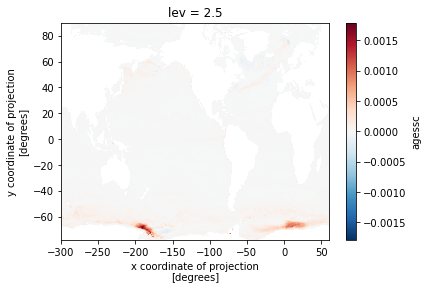

################# < 1 minutes##################
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
#################CMIP.NOAA-GFDL.GFDL-ESM4.historical.r1i1p1f1.Omon.gr.none  (2/6)##################
File exists: Skipping rechunking


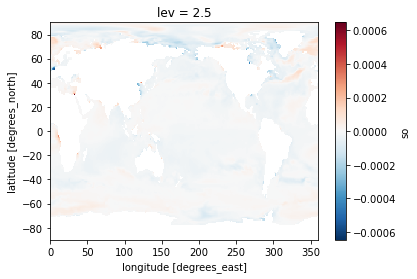

################# < 1 minutes##################
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
#################CMIP.NOAA-GFDL.GFDL-ESM4.historical.r1i1p1f1.Omon.gr.none  (3/6)##################
File exists: Skipping rechunking


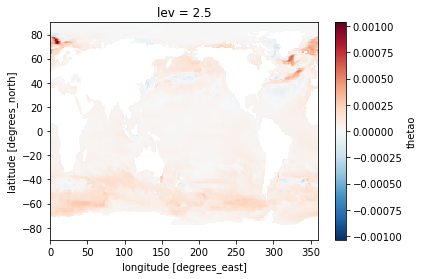

################# < 1 minutes##################
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
#################CMIP.NOAA-GFDL.GFDL-ESM4.historical.r1i1p1f1.Omon.gn.none  (4/6)##################
File exists: Skipping rechunking


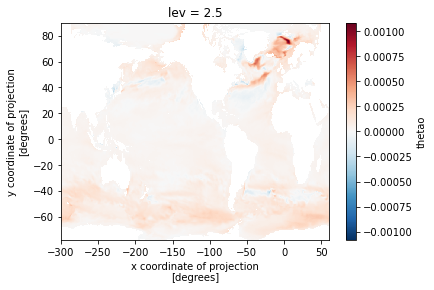

################# < 1 minutes##################
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
#################CMIP.NOAA-GFDL.GFDL-ESM4.historical.r1i1p1f1.Omon.gr.none  (5/6)##################
File exists: Skipping rechunking


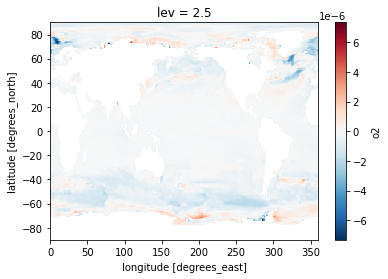

################# < 1 minutes##################
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
#################CMIP.NOAA-GFDL.GFDL-ESM4.historical.r1i1p1f1.Omon.gn.none  (6/6)##################
moving on
$ Saving 0.11945016GB to ../../data/external/cmip6_control_drifts/CMIP.NOAA-GFDL.GFDL-ESM4.historical.r1i1p1f1.Omon.gn.none.so.nc


/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-package

$ Reloading file


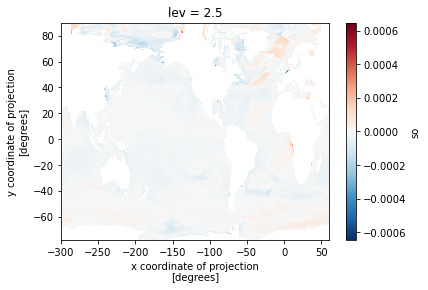

################# < 13 minutes##################


In [12]:
missed_names = []
duplicate_versions = []

# This logic should make its way into cmip6_pp
trends = {}

for mi, (name, ds) in enumerate(ddict_historical.items()):
    start = time.time()
    print('$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$')
    print(f'#################{cmip6_dataset_id(ds)}  ({mi+1}/{len(ddict_historical)})##################')
    
    
    # set triggers
    skip = False
    
    nanmask = np.isnan(ds[ds.attrs['variable_id']].isel(time=slice(0,12))).all('time').load()

    # get potential matches

    rough_match = _match_datasets(
        ds,
        ddict_control_rechunked,
        match_attrs=["source_id", "grid_label", "variable_id", "table_id"],
        pop=False,
    )

    # match parent attributes
    exact_match = []
    match_attrs_parent = ["variant_label", "source_id", "experiment_id"]
    for ds_match in rough_match:
        if all(
            [
                ds.attrs["parent_" + ma] == ds_match.attrs[ma]
                for ma in match_attrs_parent
            ]
        ):
            exact_match.append(ds_match)
    
    if len(exact_match) == 0:
        print("Did not find a match for ...")
        missed_names.append(name)
    elif len(exact_match) > 1:
        print(
            "!!!!!!!!!!!!!!!!!!!!!!!!This should not happen. Found more than one matching control run."
        )
        duplicate_versions.append(name)
    else:
        
        filepath = ofolder.joinpath(f"{cmip6_dataset_id(ds)}.{'_'.join(list(ds.data_vars))}.nc")
        
        ds_parent = exact_match[0]

        if filepath.exists():
            print('File exists: Skipping rechunking')
        else:

            try:
                start 
                print('moving on')
                # catch non match before calculating anything
                _ = calculate_drift(
                    ds_parent, ds, ds.attrs["variable_id"],
                )

                # delete the encoding (I thought this was solved?) and the upsetting intake attrs 
                ds_parent = clean(ds_parent)

                trend = calculate_drift(
                    ds_parent, ds, ds.attrs["variable_id"],
                )
                # mask out nans
                trend = trend.where(~nanmask)
                
                trend_reloaded = write(
                    clean(trend),
                    filepath,
                    force_load=True,
                    serialize_load_over_dim=False,
                    overwrite=False,
                )
                trends[cmip6_dataset_id(ds)] = trend_reloaded
                
                # check attrs
                for att in ['source_id', 'variable_id', 'variant_label', 'grid_label']:
                    assert trend_reloaded.attrs[att] == ds.attrs[att]
                
            except Exception as e:
                missed_names.append(name)
                print(f"Could not write {cmip6_dataset_id(ds)} due to {e}")
                
        
        try:
            trend_reloaded = xr.open_dataset(filepath, chunks={'lev':1})
            # check attrs
            for att in ['source_id', 'variable_id', 'variant_label', 'grid_label']:
                assert trend_reloaded.attrs[att] == ds.attrs[att]
            plt.figure()
            trend_reloaded[trend_reloaded.attrs['variable_id']].isel(lev=0).plot()
            plt.show()
        except Exception as e:
            print(f"Plotting failed with {e}")
            
            
        try:
            
            # delete partially or fully empty ones (this is nested improperly...this failes if there is no file to load...s)
            nanmask = np.isnan(ds[ds.attrs['variable_id']].isel(time=slice(0,12))).all('time')
            nantrend = np.isnan(trend_reloaded[trend_reloaded.attrs['variable_id']])
            if not np.isclose(nanmask, nantrend).all():
                print('NON MATCHING MASK DETECTED. Deleting dataset')
                os.remove(filepath)
                missed_names.append(name)
                
        except Exception as e:
            print(f"Nancheck failed with {e}")
        
    stop = time.time()
    print(f'################# < {int(np.ceil((stop-start)/60))} minutes##################')

## Clean out temp files

In [10]:
# import shutil
# shutil.rmtree(tempfolder)